In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

import utils
from model.loss import *
import phate
import umap 
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
rna_dataset = symsim2_rna(counts_dir = "./data/symsim2/tri_rand1/GxC1.txt", anno_dir = "./data/symsim2/tri_rand1/cell_label1.txt", anchor = "6_2")
atac_dataset = symsim2_atac(counts_dir = "./data/symsim2/tri_rand1/RxC2.txt", anno_dir = "./data/symsim2/tri_rand1/cell_label2.txt", anchor = "6_2")

In [3]:
fig_dir = "./result/symsim2/tri_rand1/"

In [4]:
rna_CONFIG = { 
    'in_features': 1000,
    'layers': [512, 256, 64, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 3000,
    'layers': [512, 256, 64, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    X_umap1 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    X_tsne1 = TSNE(n_components = 2).fit_transform(data["count"].numpy())
    X_phate1 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_atac_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)
    X_umap2 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    X_tsne2 = TSNE(n_components = 2).fit_transform(data["count"].numpy())
    X_phate2 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())

Calculating PHATE...
  Running PHATE on 482 observations and 1000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.05 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.09 seconds.
  Calculating optimal t...
    Automatically selected t = 14
  Calculated optimal t in 0.25 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.15 seconds.
Calculated PHATE in 0.51 seconds.
Calculating PHATE...
  Running PHATE on 450 observations and 3000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.14 seconds.
  Calculating optimal

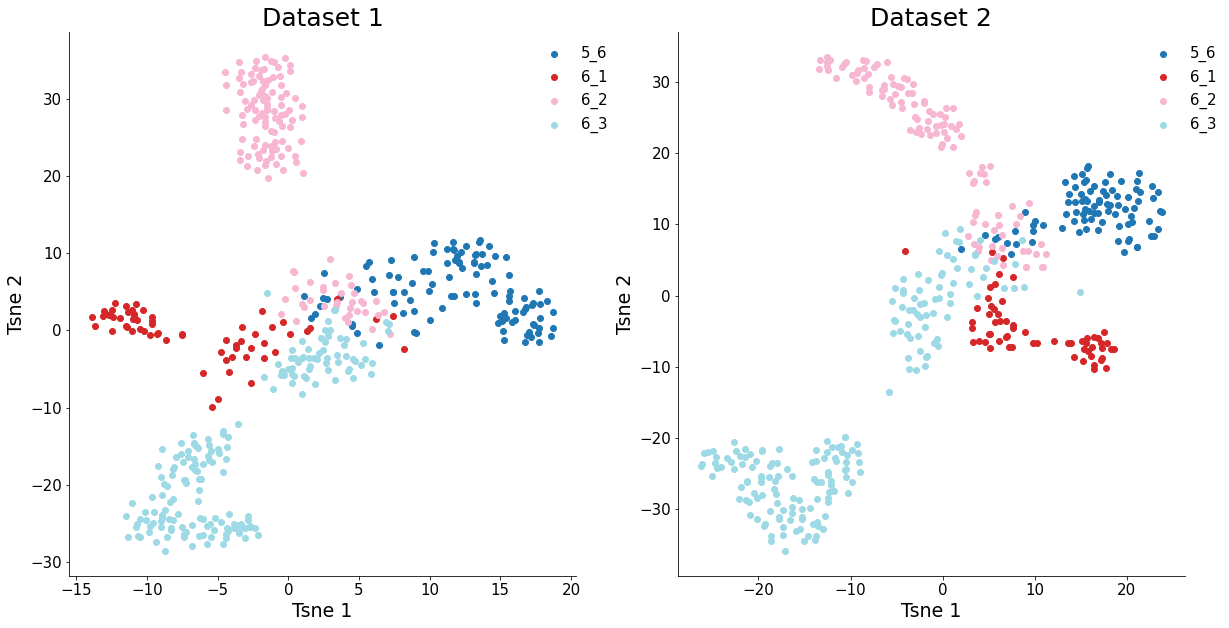

In [5]:
utils.plot_latent(z1 = X_tsne1, z2 = X_tsne2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = fig_dir + "tsne.png", axis_label = "Tsne")

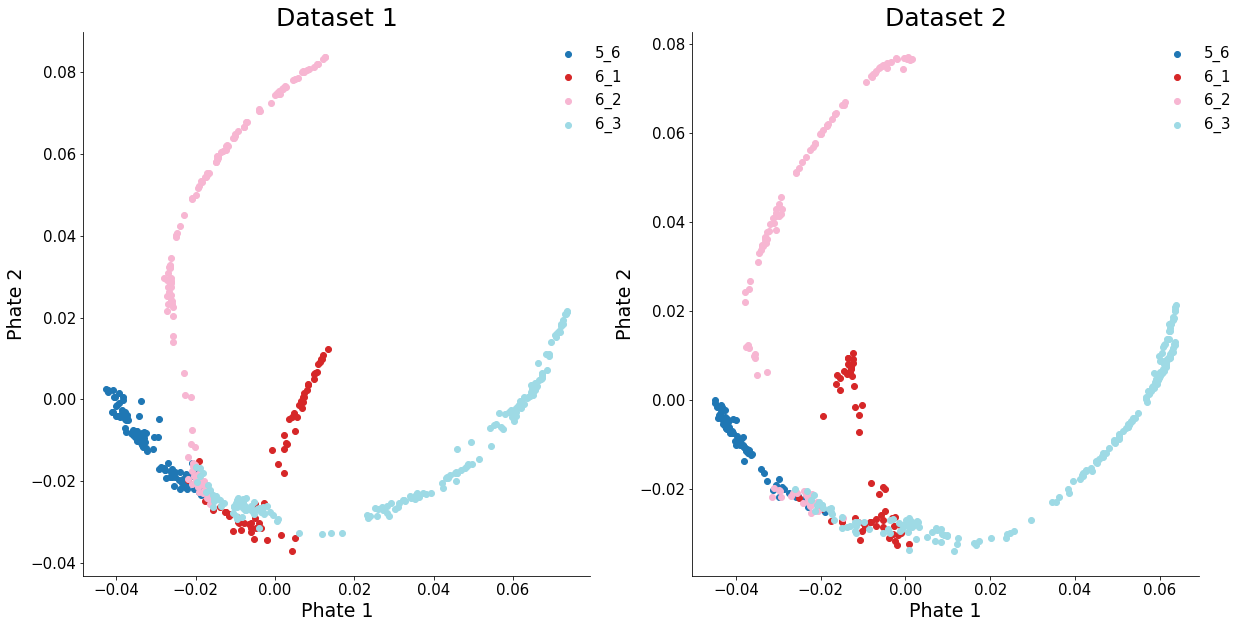

In [6]:
utils.plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = fig_dir + "phate.png",axis_label = "Phate")

In [5]:
encoder1 = ae.Encoder(rna_CONFIG)
encoder2 = ae.Encoder(atac_CONFIG)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 1e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 1e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()), lr = 5e-4)
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()), lr = 5e-4)


In [6]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [7]:
utils.pretrain_embedding(encoder1 = encoder1, encoder2 = encoder2, fusion = fusion, decoder1 = decoder1, decoder2 = decoder2, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, n_epochs = 101, lamb_r1 = 0.5, lamb_r2 = 0.5, dist_mode = "mse")

epoch:  0 RNA recon loss: 16.28946, RNA dist loss: 0.57441 ATAC recon loss: 0.39951, ATAC dist loss: 0.62580
epoch:  10 RNA recon loss: 5.20735, RNA dist loss: 0.17014 ATAC recon loss: 0.10388, ATAC dist loss: 0.22575
epoch:  20 RNA recon loss: 2.45642, RNA dist loss: 0.13791 ATAC recon loss: 0.04554, ATAC dist loss: 0.14789
epoch:  30 RNA recon loss: 1.75205, RNA dist loss: 0.14816 ATAC recon loss: 0.02686, ATAC dist loss: 0.11106
epoch:  40 RNA recon loss: 1.42532, RNA dist loss: 0.12124 ATAC recon loss: 0.01990, ATAC dist loss: 0.10811
epoch:  50 RNA recon loss: 1.22117, RNA dist loss: 0.12640 ATAC recon loss: 0.01697, ATAC dist loss: 0.10027
epoch:  60 RNA recon loss: 1.07213, RNA dist loss: 0.11467 ATAC recon loss: 0.01364, ATAC dist loss: 0.10069
epoch:  70 RNA recon loss: 0.95221, RNA dist loss: 0.11761 ATAC recon loss: 0.01194, ATAC dist loss: 0.09082
epoch:  80 RNA recon loss: 0.85403, RNA dist loss: 0.12612 ATAC recon loss: 0.00953, ATAC dist loss: 0.10353
epoch:  90 RNA reco

In [8]:
# # add recon can help reduce the dist_loss
# utils.pre_train_ae(encoder = encoder1, decoder = decoder1, fusion = fusion, data_loader = train_rna_loader, diff_sim = Diff1, recon_opt = optimizer_rna, dist_opt = optimizer_dist_rna, n_epochs = 101, lambda_r = 1, dist_mode = "mse")

In [9]:
# utils.pre_train_ae(encoder = encoder2, decoder = decoder2, fusion = fusion, data_loader = train_atac_loader, diff_sim = Diff2, recon_opt = optimizer_atac, dist_opt = optimizer_dist_atac,  n_epochs = 101, lambda_r = 1, dist_mode = "mse")

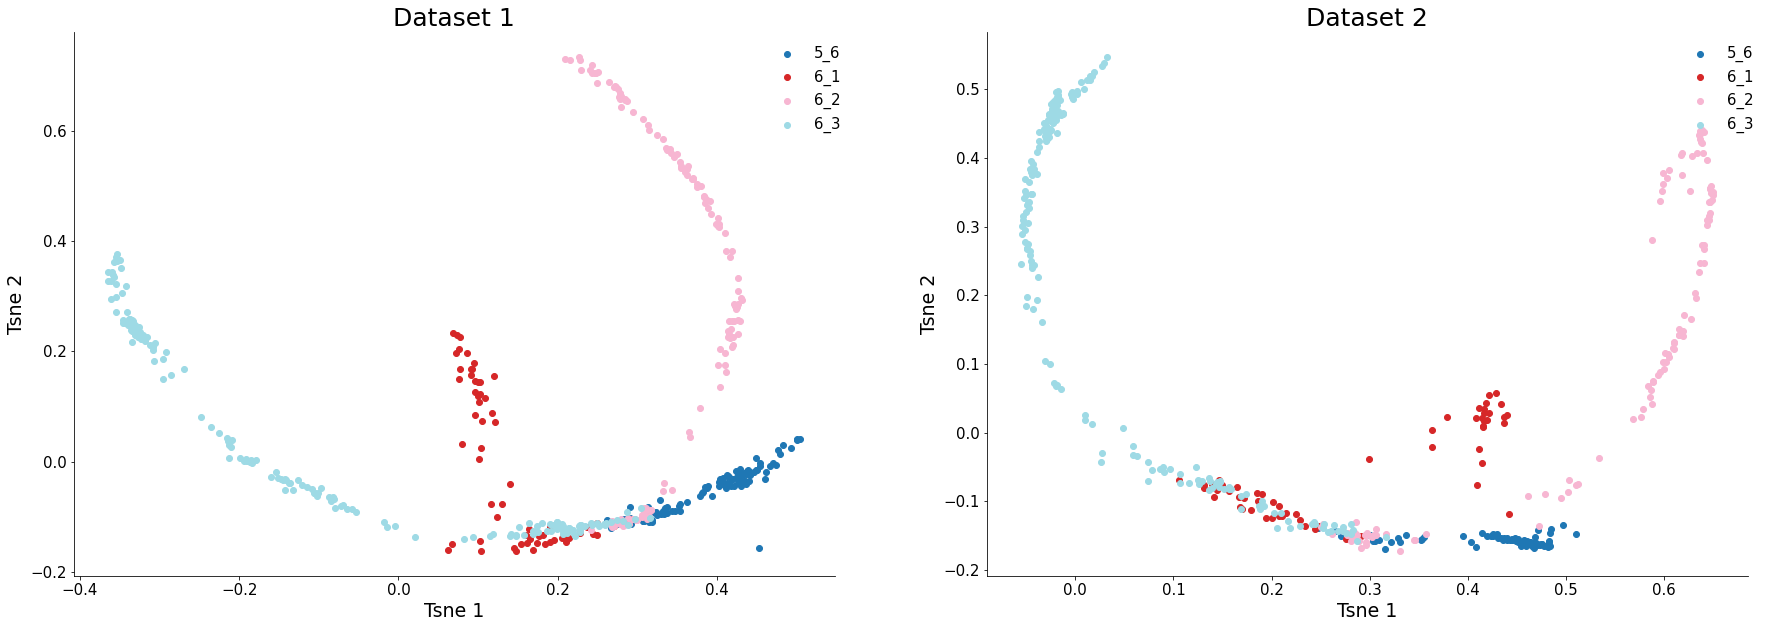

In [10]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None, figsize = (30,10))

In [11]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 201, use_anchor = True)

epoch:  0 Discriminator loss: 0.68052
epoch:  10 Discriminator loss: 0.66912
epoch:  20 Discriminator loss: 0.63640
epoch:  30 Discriminator loss: 0.57197
epoch:  40 Discriminator loss: 0.51441
epoch:  50 Discriminator loss: 0.43103
epoch:  60 Discriminator loss: 0.37673
epoch:  70 Discriminator loss: 0.29091
epoch:  80 Discriminator loss: 0.24361
epoch:  90 Discriminator loss: 0.18239
epoch:  100 Discriminator loss: 0.23488
epoch:  110 Discriminator loss: 0.18080
epoch:  120 Discriminator loss: 0.16325
epoch:  130 Discriminator loss: 0.13022
epoch:  140 Discriminator loss: 0.08949
epoch:  150 Discriminator loss: 0.15588
epoch:  160 Discriminator loss: 0.10226
epoch:  170 Discriminator loss: 0.08448
epoch:  180 Discriminator loss: 0.07878
epoch:  190 Discriminator loss: 0.07476
epoch:  200 Discriminator loss: 0.06824


In [18]:
# n_iter = 200 merge too good
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=201, n_iter=120, n_iter2 = 7, lamb_r1 = 1, lamb_r2 = 1, lamb_disc=1, dist_mode = "mse", use_anchor = True)

epoch:  0 RNA recon loss: 0.29542, RNA dist loss: 0.17056 ATAC recon loss: 0.02471, ATAC dist loss: 0.15951 Discriminator loss: 0.68116
epoch:  10 RNA recon loss: 0.27242, RNA dist loss: 0.14237 ATAC recon loss: 0.01976, ATAC dist loss: 0.14482 Discriminator loss: 0.68268
epoch:  20 RNA recon loss: 0.24689, RNA dist loss: 0.15313 ATAC recon loss: 0.01987, ATAC dist loss: 0.15077 Discriminator loss: 0.68130
epoch:  30 RNA recon loss: 0.22220, RNA dist loss: 0.15572 ATAC recon loss: 0.02032, ATAC dist loss: 0.21721 Discriminator loss: 0.59181
epoch:  40 RNA recon loss: 0.21026, RNA dist loss: 0.12859 ATAC recon loss: 0.02055, ATAC dist loss: 0.13511 Discriminator loss: 0.65987
epoch:  50 RNA recon loss: 0.19139, RNA dist loss: 0.24887 ATAC recon loss: 0.02139, ATAC dist loss: 0.29830 Discriminator loss: 0.61572
epoch:  60 RNA recon loss: 0.17602, RNA dist loss: 0.19253 ATAC recon loss: 0.02505, ATAC dist loss: 0.15659 Discriminator loss: 0.66804
epoch:  70 RNA recon loss: 0.15987, RNA di

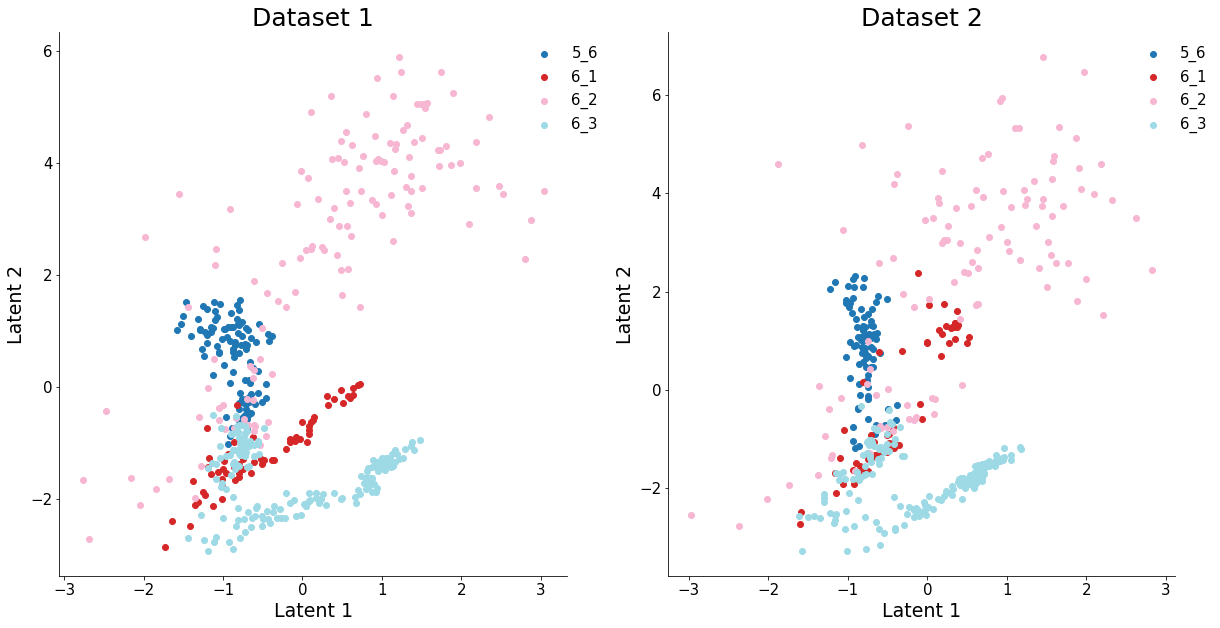

In [19]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = (encoder1(data['count'].to(device))).cpu().detach().numpy()[:,0:2]

    for data in test_atac_loader:
        ae_coordinates2 = (encoder2(data['count'].to(device))).cpu().detach().numpy()[:,0:2]

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [14]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = (encoder1(data['count'].to(device))).cpu().detach().numpy()[:,2:4]

    for data in test_atac_loader:
        ae_coordinates2 = (encoder2(data['count'].to(device))).cpu().detach().numpy()[:,2:4]

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

IndexError: index 0 is out of bounds for axis 1 with size 0

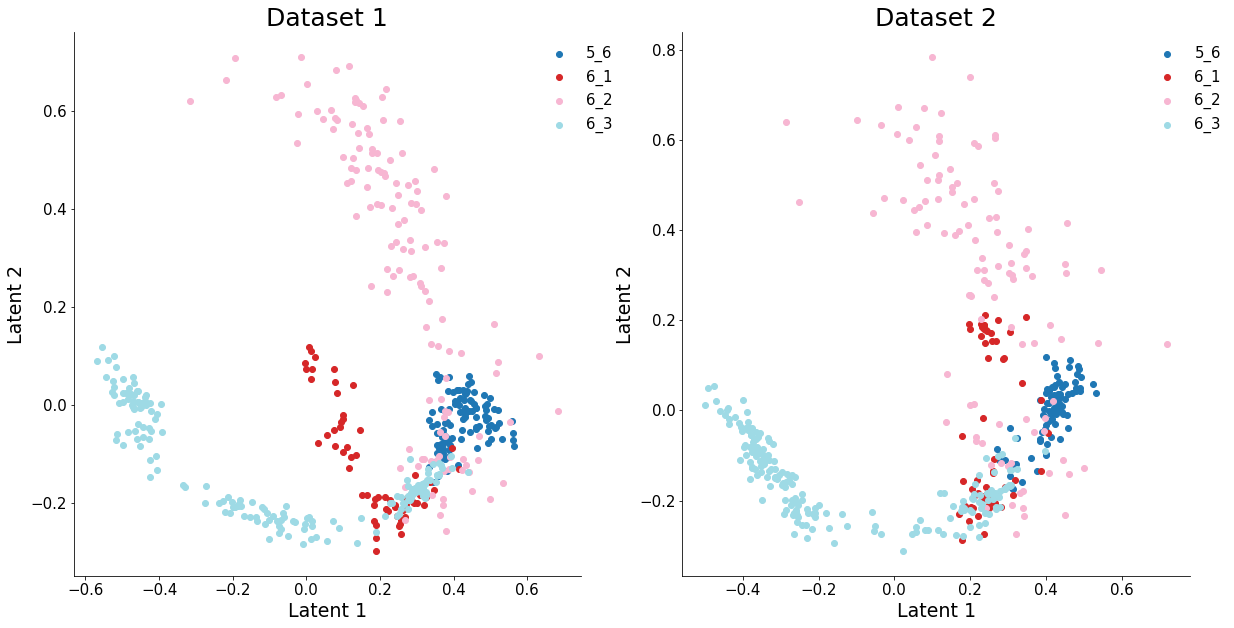

In [20]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

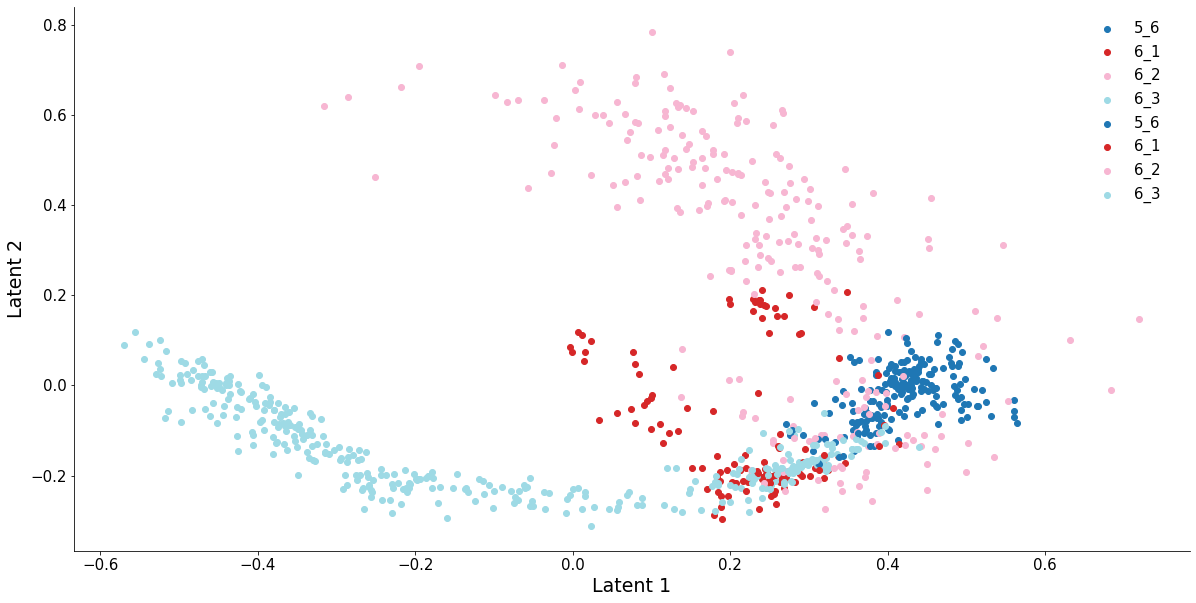

In [21]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = None)

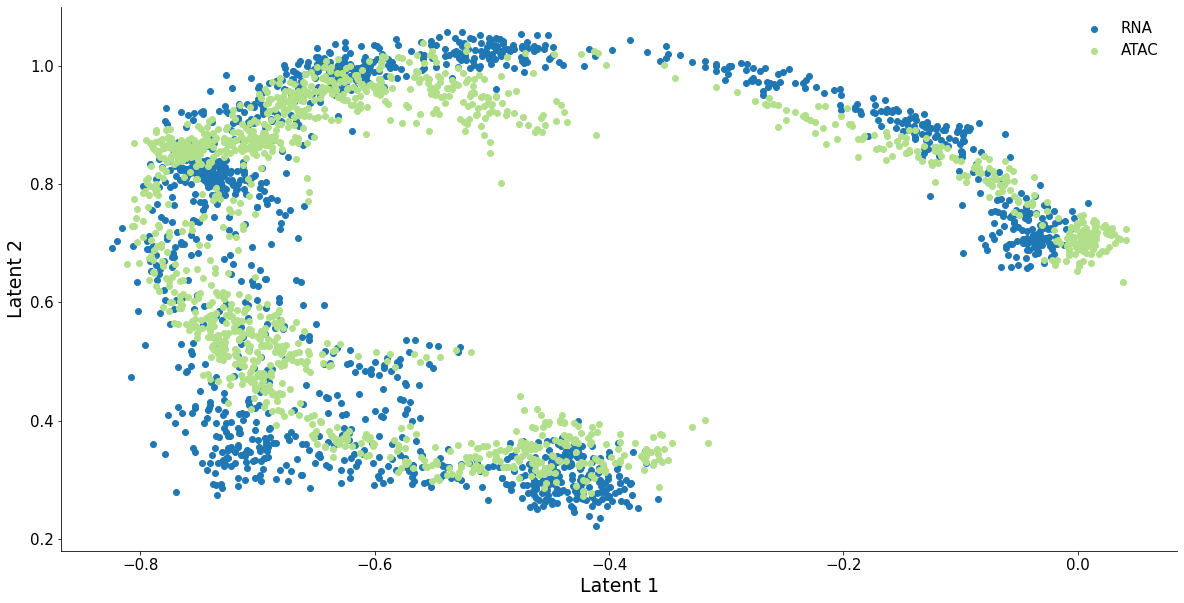

In [18]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality",save = None)

In [17]:
torch.save({
    'encoder1': encoder1.state_dict(),
    'encoder2': encoder2.state_dict(),
    'disc': disc.state_dict(),
    'fusion': fusion.state_dict(),
    'decoder1': decoder1.state_dict(),
    'decoder2': decoder2.state_dict(),
    'config1': rna_CONFIG,
    'config2': atac_CONFIG,
    'Diff1': Diff1,
    'Diff2': Diff2
}, './saved_model/symsim2_tri_rand1.pt')

In [ ]:
# state = torch.load('./saved_model/symsim2.pt')

# encoder1 = ae.Encoder(rna_CONFIG).to(device)
# encoder1.load_state_dict(state['encoder1'])

# encoder2 = ae.Encoder(atac_CONFIG).to(device)
# encoder2.load_state_dict(state['encoder2'])

# fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 2, embed_channels = 2, activation = False, use_hidden = False)
# fusion.load_state_dict(state['fusion'])

# decoder1 = ae.Decoder(rna_CONFIG).to(device)
# decoder1.load_state_dict(state['decoder1'])

# decoder2 = ae.Decoder(atac_CONFIG).to(device)
# decoder2.load_state_dict(state['decoder2'])

# disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
# disc.load_state_dict(state['disc'])